# Digit Sequences

### Recognizing digit sequences from the Leap Motion dataset using TensorFlow

---

The following notebook details implementation of a Convolutional Neural Network to recognize sequences of digits captured using Leap Motion device . I have broken the notebook into two parts as TensorFlow programs are usually structured into a **construction phase**, that assembles a graph, and an **execution phase** that uses a session to execute ops in the graph.

Let's start by importing some libraries and load our dataset.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import time
import os
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.15.0


## Loading the data

Let's load the greyscale images created in preprocessing step

In [2]:
# Open the HDF5 file containing the datasets
h5f = h5py.File('data/mlt_leap_grey_0.h5','r')

# Extract the datasets
X_train = h5f['train_dataset'][:]
y_train = h5f['train_labels'][:]
X_test = h5f['test_dataset'][:]
y_test = h5f['test_labels'][:]

# Close the file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (6583, 64, 64, 1) (6583, 2)
Test set (1000, 64, 64, 1) (1000, 2)


Keep the data dimensions as they will be reused multiple times in the following code

In [3]:
# Get the data dimensions
_, img_height, img_width, num_channels = X_train.shape

# ... and label information
num_digits, num_labels = y_train.shape[1], len(np.unique(y_train))

In [4]:
num_digits, num_labels

(2, 11)

In [5]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

Let's shuffle the training set using ``sklearn.utils.shuffle``

In [6]:
from sklearn.utils import shuffle

# Randomly shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

### Data Preprocessing

Mean subtraction is the most common form of preprocessing. It involves subtracting the mean across every individual feature in the data, and has the geometric interpretation of centering the cloud of data around the origin along every dimension. [``Goodfellow et al.``](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf) (96.03%) and [``Ba et al.``](https://arxiv.org/pdf/1412.7755.pdf) (96.1%) both preprocess the images by subtracting the mean of every image.

In [7]:
def subtract_mean(a):
    """ Helper function for subtracting the mean of every image
    """
    for i in range(a.shape[0]):
        a[i] -= a[i].mean()
    return a


# Subtract the mean from every image
X_train = subtract_mean(X_train)
X_test = subtract_mean(X_test)

## Helper functions

Let's implement some helper functions to make our notebook easier to read and reduce code duplication.

### Helper function for plotting images

Here is a simple helper function that will help us plot ``nrows`` * ``ncols`` images and their true and predicted labels.

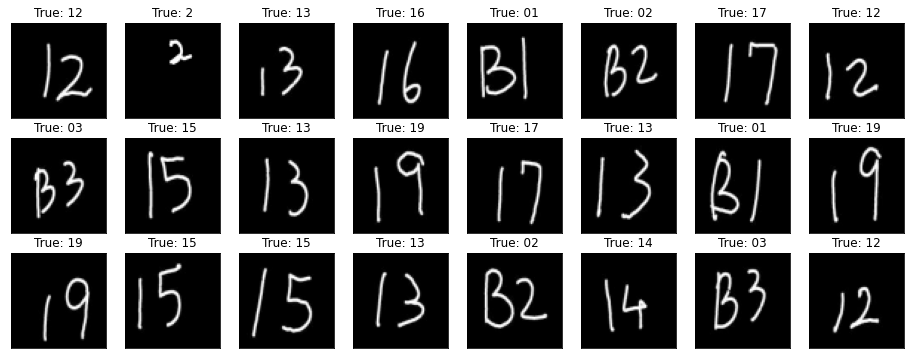

In [8]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    # Initialize figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Pretty string with actual number
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted number
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
            
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
        
# Plot some images from the training set
plot_images(X_train, 3, 8, y_train)

### Helper functions for creating new variables

Functions for creating new [``TensorFlow Variables``](https://www.tensorflow.org/how_tos/variables/) in the given shape and initializing them using using the initialization scheme porposed by [``Gloret et al.``](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf)

In [9]:
tf.reset_default_graph() 
def init_conv_weights(shape, name):
    return tf.get_variable(name, shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def init_fc_weights(shape, name):
    return tf.get_variable(name, shape, initializer=tf.contrib.layers.xavier_initializer())

def init_biases(shape):
    return tf.Variable(tf.constant(0.0, shape=shape))

### Helper function for stacking CONV-RELU layers followed by an optional POOL layer

This function creates a new convolutional layer in the computational graph for TensorFlow. The most common form of a ConvNet architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size. At some point it is common to transition to fully connected layers.

In other words, the most common ConvNet archiecture follows the pattern:

```INPUT > [[CONV -> RELU]*N -> POOL?]M -> [FC -> RELU]*K -> FC```

The following helper function simplifies the creation of this pattern

In [10]:
def conv_layer(input_tensor,    # The input or previous layer
                filter_size,    # Width and height of each filter
                in_channels,    # Number of channels in previous layer
                num_filters,    # Number of filters
                layer_name,     # Layer name
                pooling):       # Use 2x2 max-pooling?
    
    # Add layer name scopes for better graph visualization
    with tf.name_scope(layer_name):
    
        # Shape of the filter-weights for the convolution
        shape = [filter_size, filter_size, in_channels, num_filters]

        # Create weights and biases
        weights = init_conv_weights(shape, layer_name + '/weights')
        biases = init_biases([num_filters])
        
        # Add histogram summaries for weights
        tf.summary.histogram(layer_name + '/weights', weights)
        
        # Create the TensorFlow operation for convolution, with S=1 and zero padding
        activations = tf.nn.conv2d(input_tensor, weights, [1, 1, 1, 1], 'SAME') + biases

        # Rectified Linear Unit (ReLU)
        activations = tf.nn.relu(activations)

        # Do we insert a pooling layer?
        if pooling:
            # Create a pooling layer with F=2, S=1 and zero padding
            activations = tf.nn.max_pool(activations, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')

        # Return the resulting layer
        return activations

### Helper function for reshaping the CONV layers to FC layers

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer. E.g., if the input layer has the shape (?, 8, 8, 32) the flattened layer will have the shape (?, 8 x 8 x 32) or (?, 2048).

In [11]:
def flatten_tensor(input_tensor):
    """ Helper function for transforming a 4D tensor to 2D
    """
    # Get the shape of the input_tensor.
    input_tensor_shape = input_tensor.get_shape()

    # Calculate the volume of the input tensor
    num_activations = input_tensor_shape[1:4].num_elements()
    
    # Reshape the input_tensor to 2D: (?, num_activations)
    input_tensor_flat = tf.reshape(input_tensor, [-1, num_activations])

    # Return the flattened input_tensor and the number of activations
    return input_tensor_flat, num_activations

### Helper function for stacking FC-RELU layers

This function creates a new fully-connected layer in the computational graph for TensorFlow. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. Their activations can hence be computed with a matrix multiplication followed by a bias offset.

As mentioned in previous section most ConvNet architectures follows the following pattern:

```INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC```

The following helper function will simplify the process of stacking FC and RELU layers

In [12]:
def fc_layer(input_tensor,  # The previous layer,         
             input_dim,     # Num. inputs from prev. layer
             output_dim,    # Num. outputs
             layer_name,    # The layer name
             relu=False):         # Use ReLU?

    # Add layer name scopes for better graph visualization
    with tf.name_scope(layer_name):
    
        # Create new weights and biases.
        weights = init_fc_weights([input_dim, output_dim], layer_name + '/weights')
        biases = init_biases([output_dim])
        
        # Add histogram summaries for weights
        tf.summary.histogram(layer_name + '/weights', weights)

        # Calculate the layer activation
        activations = tf.matmul(input_tensor, weights) + biases

        # Use ReLU?
        if relu:
            activations = tf.nn.relu(activations)

        return activations

## Tensorflow Model

The configuration of the Convolutional Neural Network and data dimensions are defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

In [13]:
# Block 1
filter_size1 = filter_size2 = 5          
num_filters1 = num_filters2 = 32        

# Block 2
filter_size3 = filter_size4 = 5          
num_filters3 = num_filters4 = 64

# Block 3
filter_size5 = filter_size6 = filter_size7 = 5          
num_filters5 = num_filters6 = num_filters7 = 128  

# Fully-connected layers
fc1_size = fc2_size = 256

### Placeholder Variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph

In [14]:
with tf.name_scope("input"):
    
    # Placeholders for feeding input images
    x = tf.placeholder(tf.float32, shape=(None, img_height, img_width, num_channels), name='x')
    y_ = tf.placeholder(tf.int64, shape=[None, num_digits], name='y_')

with tf.name_scope("dropout"):
    
    # Dropout rate applied to the input layer
    p_keep_1 = tf.placeholder(tf.float32)
    tf.summary.scalar('input_keep_probability', p_keep_1)

    # Dropout rate applied after the pooling layers
    p_keep_2 = tf.placeholder(tf.float32)
    tf.summary.scalar('conv_keep_probability', p_keep_2)

    # Dropout rate using between the fully-connected layers
    p_keep_3 = tf.placeholder(tf.float32)
    tf.summary.scalar('fc_keep_probability', p_keep_3)

### Model

We implement the following ConvNet architecture

`INPUT -> [[CONV -> RELU]*2 -> POOL]*2 -> [[CONV -> RELU]*3 -> POOL] -> [FC -> RELU]*2 -> OUTPUT`

In [15]:

# Apply dropout to the input layer
drop_input = tf.nn.dropout(x, p_keep_1) 

# Block 1
conv_1 = conv_layer(drop_input, filter_size1, num_channels, num_filters1, "conv_1", pooling=False)
conv_2 = conv_layer(conv_1, filter_size2, num_filters1, num_filters2, "conv_2", pooling=True)
drop_block1 = tf.nn.dropout(conv_2, p_keep_2) # Dropout

# Block 2
conv_3 = conv_layer(conv_2, filter_size3, num_filters2, num_filters3, "conv_3", pooling=False)
conv_4 = conv_layer(conv_3, filter_size4, num_filters3, num_filters4, "conv_4", pooling=True)
drop_block2 = tf.nn.dropout(conv_4, p_keep_2) # Dropout

# Block 3
conv_5 = conv_layer(drop_block2, filter_size5, num_filters4, num_filters5, "conv_5", pooling=False)
conv_6 = conv_layer(conv_5, filter_size6, num_filters5, num_filters6, "conv_6", pooling=False)
conv_7 = conv_layer(conv_6, filter_size7, num_filters6, num_filters7, "conv_7", pooling=True)
flat_tensor, num_activations = flatten_tensor(tf.nn.dropout(conv_7, p_keep_3)) # Dropout

# Fully-connected 1
fc_1 = fc_layer(flat_tensor, num_activations, fc1_size, 'fc_1', relu=True)
drop_fc2 = tf.nn.dropout(fc_1, p_keep_3) # Dropout

# Fully-connected 2
fc_2 = fc_layer(drop_fc2, fc1_size, fc2_size, 'fc_2', relu=True)

# Paralell softmax layers
logits_1 = fc_layer(fc_2, fc2_size, num_labels, 'softmax1')
logits_2 = fc_layer(fc_2, fc2_size, num_labels, 'softmax2')
#logits_3 = fc_layer(fc_2, fc2_size, num_labels, 'softmax3')
#logits_4 = fc_layer(fc_2, fc2_size, num_labels, 'softmax4')
#logits_5 = fc_layer(fc_2, fc2_size, num_labels, 'softmax5')

y_pred = tf.stack([logits_1, logits_2])
print(y_pred.shape)

# The class-number is the index of the largest element
y_pred_cls = tf.transpose(tf.argmax(y_pred, axis=2))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(2, ?, 11)


### Loss Function

We calculate the loss by taking the average loss of every individual example for each of our 2 digits and adding them together. Using ``tf.nn.sparse_softmax_cross_entropy_with_logits`` allows us to skip using OneHotEncoding on our label values.

In [16]:
with tf.name_scope('loss'):
    
    # Calculate the loss for each individual digit in the sequence
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_[:, 0], logits=logits_1))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_2, labels=y_[:, 1]))
    #loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_3,labels= y_[:, 2]))
    #loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_4, labels=y_[:, 3]))
    #loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_5, labels=y_[:, 4]))

    # Calculate the total loss for all predictions
    #loss = loss1 + loss2 + loss3 + loss4 + loss5
    loss = loss1 + loss2
    tf.summary.scalar('loss', loss)

### Optimization Method

In training deep networks, it is usually helpful to anneal the learning rate over time. Typical values might be reducing the learning rate by a half every 5 epochs. Using a batch size of 64 gives us 3600 steps per epoch or 18,000 steps for 5 ephocs. A typical sampling of the starting learning rate could looks something like this:

In [17]:
10 ** np.random.uniform(-6, 1)

0.00010022814674298462

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the RMS which is an advanced form of Gradient Descent. Adam is currently the recommended optimizer but RMSProp and SGD + Nesterov Momentum are also good alternatives. For more information on Per-parameter adaptive learning rate methods see the [``CS231n notes``](http://cs231n.github.io/neural-networks-3/#ada). 

In [18]:
with tf.name_scope('optimizer'):
    
    # Global step is required to compute the decayed learning rate
    global_step = tf.Variable(0, trainable=False)

    # Apply exponential decay to the learning rate
    learning_rate = tf.train.exponential_decay(1e-3, global_step, 7500, 0.5, staircase=True)
    tf.summary.scalar('learning_rate', learning_rate)

    # Construct a new Adam optimizer
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Evaluation Metric

To evaluate the performance of our Convolutional Network we calculate the average accuracy across all samples

In [19]:
with tf.name_scope("accuracy"):
    
    # Predicted class equals the true class of each image?
    correct_prediction = tf.reduce_min(tf.cast(tf.equal(y_pred_cls, y_), tf.float32), 1)

    # Cast predictions to float and calculate the mean
    accuracy = tf.reduce_mean(correct_prediction) * 100.0
    
    # Add scalar summary for accuracy tensor
    tf.summary.scalar('accuracy', accuracy)

### TensorFlow Run

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [20]:
# Launch the graph in a session
session = tf.Session()

In order to save the variables of the neural network, so they can be reloaded quickly without having to train the network again, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph.

First we try to restore the latest checkpoint. This will fail if you have changed the TensorFlow graph or a checkpoint does not exist

In [22]:
saver = tf.train.Saver()

save_path = os.path.join('C:/Users/rashi/Desktop/Elevator/multi-digit-leap-motion/checkpoints/', 'mlt_leap_v3-6000')

# Use TensorFlow to find the latest checkpoint - if any
try:
    print("Restoring last checkpoint ...")
    
    # Finds the filename of latest saved checkpoint file
    #last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_path)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=save_path)
    print("Restored checkpoint from:", save_path)
    
# If the above failed - initialize all the variables
except:
    print("Failed to restore checkpoint - initializing variables")
    session.run(tf.global_variables_initializer())

Restoring last checkpoint ...
INFO:tensorflow:Restoring parameters from C:/Users/rashi/Desktop/Elevator/multi-digit-leap-motion/checkpoints/mlt_leap_v3-6000
Restored checkpoint from: C:/Users/rashi/Desktop/Elevator/multi-digit-leap-motion/checkpoints/mlt_leap_v3-6000


To write our TensorBoard summaries we will use the ``tf.summary.FileWriter`` class. We will create two seperate log files one for the training set and one for the validation set

In [23]:
LOG_DIR = 'logs/mlt_leap_v3/'

# Merge all the summaries and write them out to /logs/svhn_multi
merged = tf.summary.merge_all()

# Pass the graph to the writer to display it in TensorBoard
train_writer = tf.summary.FileWriter(LOG_DIR + '/train', session.graph)
validation_writer = tf.summary.FileWriter(LOG_DIR + '/validation')

## Optimization

Let's optimize or train our network. The batch size is the number of training examples we compute the gradient over during training while the dropout rates control the amount of dropout (the percentage of random units that is removed) applied in the different layers of the model.

In [24]:
# If you run out of memory - switch to a smaller batch size
batch_size = 128 

# Dropout applied to the input layer
d1 = 0.9

# Dropout applied between the conv layers
d2 = 0.75

# Dropout applied to the fully-connected layers
d3 = 0.5 

In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The following helper function simplifies the creation of fetching a new batch of data. Feeding over 10,000 samples as once (the test set) is also sure to cause some memory problems. The second function splits the validation and test set into batches and calculates the accuracy over all of the batches.

In [25]:
def feed_dict(step=0):
    """ Make a TensorFlow feed_dict mapping data onto the placeholders
    """
    # Calculate the offset
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    
    # Get the batch data
    xs, ys = X_train[offset:offset + batch_size], y_train[offset:offset+batch_size]
        
    return {x: xs, y_: ys, p_keep_1: d1, p_keep_2: d2, p_keep_3: d3}


def evaluate_batch(test, batch_size):
    """ Evaluate in batches to avoid out-of-memory issues
    """
    # Store the cumulative accuracy over all batches
    cumulative_accuracy = 0.0
    
    # Get the number of images
    n_images = y_test.shape[0] if test else y_val.shape[0]
    
    # Numer of batches needed to evaluate all images
    n_batches = n_images // batch_size + 1
    
    # Iterate over all the batches
    for i in range(n_batches):
        
        # Calculate the offset
        offset = i * batch_size
     
        if test:
            # Get the batch from the test set
            xs, ys = X_test[offset:offset+batch_size], y_test[offset:offset+batch_size]
        else:
            # Get batch from the validation set
            xs, ys = X_val[offset:offset+batch_size], y_val[offset:offset+batch_size]
            
        cumulative_accuracy += session.run(accuracy,
                {x: xs, y_: ys, p_keep_1: 1., p_keep_2: 1., p_keep_3: 1.})
                                           
    # Return the average accuracy over all batches
    return cumulative_accuracy / (0.0 + n_batches)

In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. 

In [26]:
def optimize(num_iterations, display_step):
    # Start-time used for printing time-usage
    start_time = time.time()

    for step in range(num_iterations):

        # Run the optimizer using this batch of training data.
        summary, i, _ = session.run([merged, global_step, optimizer], feed_dict(step))
        train_writer.add_summary(summary, i)

        # Print the status every display_step iteration and last
        if (i % display_step == 0) or (step == num_iterations - 1):
            
            # Calculate the minibatch accuracy
            batch_acc = session.run(accuracy, feed_dict=feed_dict(step))
            print("Minibatch accuracy at step %d: %.4f" % (i, batch_acc))

    # Total training time
    run_time = time.time() - start_time
    print("\nTime usage: " + str(timedelta(seconds=int(round(run_time)))))
    
    # Calculate and display the testset accuracy
    test_acc = evaluate_batch(test=True, batch_size=512)
    print("Test accuracy: %.4f" % test_acc)
    
    # Save all the variables of the TensorFlow graph
    saver.save(session, save_path=save_path, global_step=global_step)
    print('Model saved in file: {}'.format(save_path))

Let's run 5,000 iterations and see how well our model performs. When tuning the hyperparameters of the model it could we smart do to a quick search of 1-5 ephocs (complete forward and backward passes over the dataset)

In [36]:
optimize(num_iterations=6000, display_step=200)

Minibatch accuracy at step 200: 90.6250
Minibatch accuracy at step 400: 97.6562
Minibatch accuracy at step 600: 100.0000
Minibatch accuracy at step 800: 99.2188
Minibatch accuracy at step 1000: 100.0000
Minibatch accuracy at step 1200: 98.4375
Minibatch accuracy at step 1400: 99.2188
Minibatch accuracy at step 1600: 99.2188
Minibatch accuracy at step 1800: 100.0000
Minibatch accuracy at step 2000: 100.0000
Minibatch accuracy at step 2200: 99.2188
Minibatch accuracy at step 2400: 99.2188
Minibatch accuracy at step 2600: 99.2188
Minibatch accuracy at step 2800: 100.0000
Minibatch accuracy at step 3000: 100.0000
Minibatch accuracy at step 3200: 100.0000
Minibatch accuracy at step 3400: 100.0000
Minibatch accuracy at step 3600: 100.0000
Minibatch accuracy at step 3800: 100.0000
Minibatch accuracy at step 4000: 99.2188
Minibatch accuracy at step 4200: 100.0000
Minibatch accuracy at step 4400: 99.2188
Minibatch accuracy at step 4600: 100.0000
Minibatch accuracy at step 4800: 100.0000
Minibat

Let's run a total of ~30 epochs to see if we can converge on a good solution!

In [ ]:
optimize(num_iterations=50000, display_step=2000)

In [ ]:
optimize(num_iterations=6000, display_step=2000)

### Testset performance

Let's plot some of the mis-classified examples in our testset and a confusion matrix showing how well our model is able to predict the different digits.

In [27]:
# Feed the test set with dropout disabled
feed_dict={
    x: X_test,
    y_: y_test,
    p_keep_1: 1.,
    p_keep_2: 1.,
    p_keep_3: 1.
}

# Generate predictions for the testset
test_pred = session.run(y_pred_cls, feed_dict=feed_dict)

# Display the predictions
test_pred

array([[ 1,  0],
       [ 1,  2],
       [ 1,  4],
       ...,
       [ 1,  3],
       [ 1,  2],
       [ 3, 10]], dtype=int64)

(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

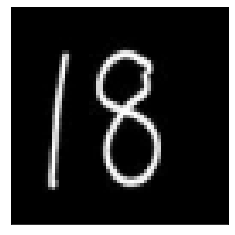

In [28]:
idx=507

plt.imshow(np.squeeze(X_test[idx,:,:,0]), cmap='binary')
plt.xticks([]), plt.yticks([])

In [29]:
img = np.expand_dims(X_test[idx], axis=0)
img_yt = np.expand_dims(y_test[idx], axis=0)
print(img.shape, img_yt)
session.run(y_pred_cls, feed_dict={x:img , y_:img_yt , p_keep_1: 1., p_keep_2: 1., p_keep_3: 1.})

(1, 64, 64, 1) [[1 8]]


array([[1, 8]], dtype=int64)

#### Individual digit accuracy

Let's calculate the classifiers accuracy on each individual digit only counting the non missing values.

In [30]:
from sklearn.metrics import accuracy_score

# Find the position of the non missing labels
non_zero = np.where(y_test.flatten() != 10)

# Calculate the accuracy on the individual didgit level
accuracy_score(test_pred.flatten()[non_zero], y_test.flatten()[non_zero])

0.9994722955145119

... and plot the confusion matrix to show the performance for each class

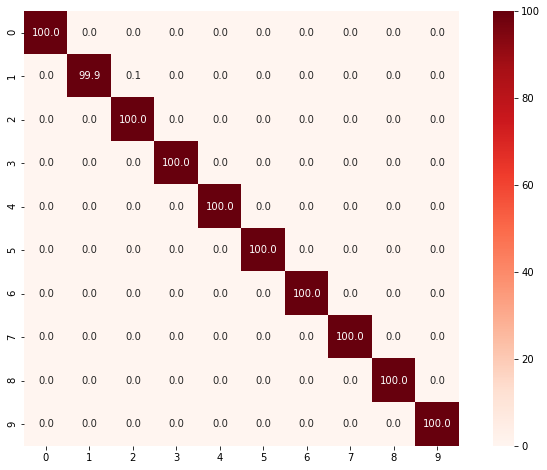

In [37]:
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_test.flatten()[non_zero], test_pred.flatten()[non_zero])

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);
plt.savefig('confusion_matrix.jpg')

#### Digit sequence lengths impact on performance

Let's see how well our model is able to predict the labels correctly for different sequence lengths

In [38]:
def calculate_accuracy(a, b):
    """ Calculating the % of similar rows in two numpy arrays 
    """
    # Compare two numpy arrays row-wise
    correct = np.sum(np.all(a == b, axis=1))
    return 100.0 * (correct / (0.0 + a.shape[0]))
    
    
# For every possible sequence length
for num_digits in range(1, 3):
    
    # Find all images with that given sequence length
    images = np.where((y_test != 10).sum(1) == num_digits)
    
    # Calculate the accuracy on those images
    acc = calculate_accuracy(test_pred[images], y_test[images])
    
    print("%d digit accuracy %.3f %%" % (num_digits, acc))

1 digit accuracy 99.048 %
2 digit accuracy 100.000 %


#### Correctly classified images

Let's find some correctly classified examples and plot the true and predicted label values

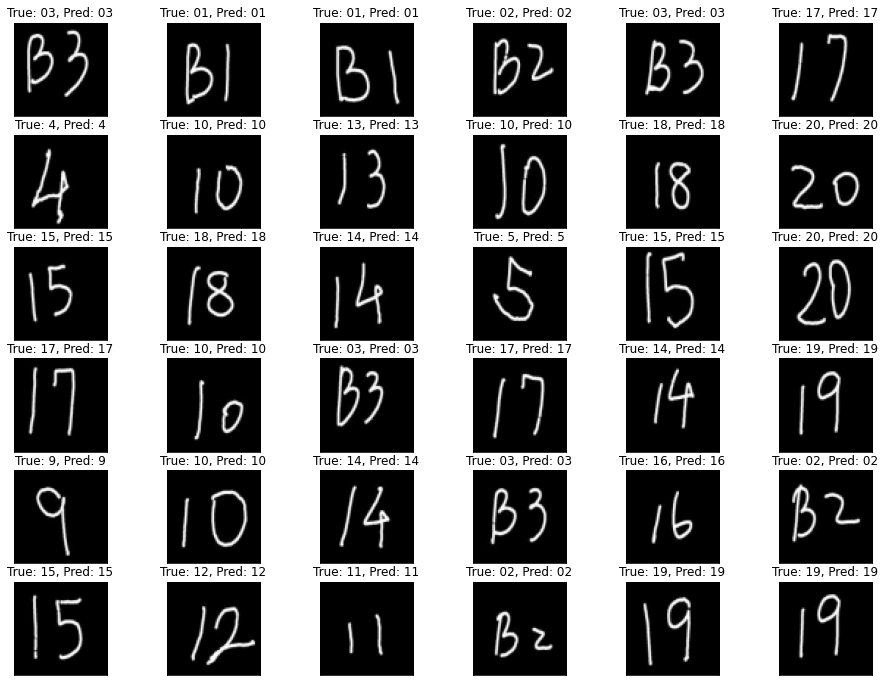

In [39]:
# Find the correctly classified examples
correct = np.array([(a==b).all() for a, b in zip(test_pred, y_test)])

# Select the incorrectly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 6, 6, cls_true, cls_pred);
plt.savefig('correctly_classified.jpg')

#### Incorrectly classified images

Let's invert the boolean array and plot some of the incorrectly classified examples

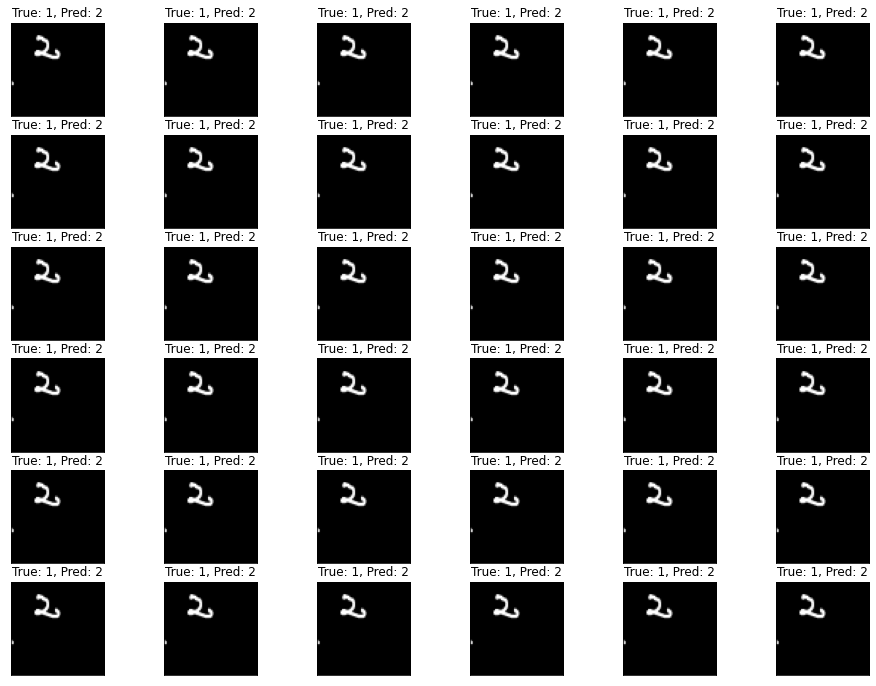

In [40]:
# Find the incorrectly classified examples
incorrect = np.invert(correct)

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 6, 6, cls_true, cls_pred);
plt.savefig('Incorrectly_classified.jpg')

Close the session

In [ ]:
#session.close()